In [12]:
import pandas as pd
from pathlib import Path
import numpy as np 
import sys
sys.path.insert(0, "..")   
from src.cluster_util import cluster_data
from src.BinaryTriFactorizationEstimator import BinaryTriFactorizationEstimator
from src.BTNMF_util import  get_normalized_assignments, explain_coverage, sweep_btf_grid, sweep_btf_grid, cluster_data_and_explain_blocks
from src.BTNMF_util import merge_blocks_by_stat, get_sorted_row_col, normalize_data_and_fit_estimator, pick_best_btf_setting
from src.data_utils import save_csv_or_parquet, generate_growth_rate_features, normalize_data, collapse_block_id_by_store_item, get_nan_stats, median_mean_transform
from src.plot_util import plot_block_annot_heatmap


In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [7]:
df = pd.read_parquet("../output/data/2014_January_top_53_store_2000_item.parquet")
df.head()

,store,item,date,store_item,unit_sales,id,onpromotion,weight
0,10,1000866,2014-01-01,10_1000866,NaN,NaN,None,1
1,10,1001305,2014-01-01,10_1001305,NaN,NaN,None,1
2,10,1003679,2014-01-01,10_1003679,NaN,NaN,None,1
3,10,1004545,2014-01-01,10_1004545,NaN,NaN,None,1
4,10,1004550,2014-01-01,10_1004550,NaN,NaN,None,1


In [8]:
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


In [9]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate.parquet")
df = pd.read_parquet(data_path)

In [10]:
df.head()

,store,item,date,store_item,unit_sales,onpromotion,weight,growth_rate
0,10,1000866,2014-01-01,10_1000866,NaN,None,1,NaN
94000,10,1000866,2014-01-02,10_1000866,NaN,None,1,NaN
188000,10,1000866,2014-01-03,10_1000866,NaN,None,1,NaN
282000,10,1000866,2014-01-04,10_1000866,NaN,None,1,NaN
376000,10,1000866,2014-01-05,10_1000866,NaN,None,1,NaN


In [13]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate.csv")
save_csv_or_parquet(df, data_path)

2025-09-25 11:45:31,363 - INFO - Saving df to ../output/data/2014_January_top_53_store_2000_item_growth_rate.csv


In [14]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered.parquet")
df = pd.read_parquet(data_path)
df.describe()

,store,item,date,unit_sales,weight,growth_rate,block_id
count,2.914000e+06,2.914000e+06,2914000,1.448386e+06,2914000.0,1.209524e+06,2896516.0
mean,2.651064e+01,9.564934e+05,2014-01-16 00:00:00.000000256,1.108910e+01,1.0,4.571560e-01,4258.29525
min,1.000000e+00,9.699500e+04,2014-01-01 00:00:00,-1.700000e+02,1.0,-4.000000e+01,878.0
25%,1.200000e+01,5.709208e+05,2014-01-08 00:00:00,2.000000e+00,1.0,-4.285714e-01,878.0
50%,2.700000e+01,1.005464e+06,2014-01-16 00:00:00,5.000000e+00,1.0,0.000000e+00,878.0
75%,4.000000e+01,1.370548e+06,2014-01-24 00:00:00,1.100000e+01,1.0,6.666667e-01,7414.0
max,5.400000e+01,1.909755e+06,2014-01-31 00:00:00,1.000000e+04,1.0,5.330000e+02,20025.0
std,1.562850e+01,4.603335e+05,NaN,2.445585e+01,0.0,2.147219e+00,5756.312783


In [15]:
df["block_id"].value_counts(dropna=False)

block_id
878      2053564
11620     148025
18178     119846
14148     103664
8830       97278
7414       93527
12228      84940
20025      81530
5846       57753
10723      56389
<NA>       17484
Name: count, dtype: Int64

In [16]:
df["block_id"].nunique()

10

In [17]:
print(df["store"].nunique())
print(df["item"].nunique())

47
2000


In [18]:
df.head()

,store,item,date,store_item,unit_sales,onpromotion,weight,growth_rate,block_id
0,10,1000866,2014-01-01,10_1000866,NaN,None,1,NaN,14148
1,10,1000866,2014-01-02,10_1000866,NaN,None,1,NaN,14148
2,10,1000866,2014-01-03,10_1000866,NaN,None,1,NaN,14148
3,10,1000866,2014-01-04,10_1000866,NaN,None,1,NaN,14148
4,10,1000866,2014-01-05,10_1000866,NaN,None,1,NaN,14148


In [10]:
norm_data = normalize_data(
        df,
        column_name="growth_rate_1",
        log_transform=False,
        median_transform=True,
        mean_transform=False,
        zscore_rows=False,
        zscore_cols=False,
)

2025-09-23 17:05:55,456 - INFO - Finite: 93859, NaNs: 0, 0.0%)


In [12]:

fn = Path("../output/data/growth_rate_2014_January_top_53_store_2000_item_cluster_bt_block_id.npy")
bids = np.load(fn, allow_pickle=True)
bids


array([[12730, 12730, 12730, ..., 12730, 12730, 12730],
       [12730, 10531, 12730, ..., 12730, 12730, 12730],
       [12730, 12730, 12730, ..., 12730, 12730, 20534],
       ...,
       [12730, 12730, 12730, ..., 12730, 12730, 12730],
       [12730, 12730, 12730, ..., 12730, 12730, 12730],
       [12730, 12730, 12730, ..., 11621, 12730, 12730]])

In [13]:
df2 = get_normalized_assignments(bids, norm_data)[
        ["store", "item", "growth_rate_1", "block_id"]
    ]
row_order, col_order = get_sorted_row_col(df2)

In [17]:
df2.head()

,store,item,growth_rate_1,block_id
0,1,96995,-62.5,12730
1,1,103501,0.0,12730
2,1,103520,0.0,12730
3,1,103665,-25.0,12730
4,1,105574,0.0,12730


In [19]:
# fn = Path("../output/figures/ train_2014_2015_top_53_store_2000_item_cluster_bt_figure.tiff")
# plot_block_annot_heatmap(
#             df2,
#             ttl="Store-SKU Clusters",
#             value_col="growth_rate_1",
#             block_col="block_id",
#             row_col="store",
#             col_col="item",
#             date_col=None,
#             row_order=row_order,
#             col_order=col_order,
#             fmt="{:.0f}",
#             cell_h=0.6,
#             cell_w=0.75,
#             font_size=11,
#             # figsize=(6, 4),
#             xlabel_size=14,
#             ylabel_size=14,
#             label_weight="bold",
#             fn=fn,
#             show_plot=False,
#     )

In [20]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians.parquet")
df = pd.read_parquet(data_path)
df.describe()

,store,item,date,unit_sales,weight,growth_rate,block_id,cluster_growth_rate_median,cluster_unit_sales_median
count,2.914000e+06,2.914000e+06,2914000,1.448386e+06,2914000.0,1.209524e+06,2896516.0,2.868862e+06,2.882689e+06
mean,2.651064e+01,9.564934e+05,2014-01-16 00:00:00.000000256,1.108910e+01,1.0,4.571560e-01,4258.29525,4.117689e-02,4.850772e+00
min,1.000000e+00,9.699500e+04,2014-01-01 00:00:00,-1.700000e+02,1.0,-4.000000e+01,878.0,-4.937329e-01,2.000000e+00
25%,1.200000e+01,5.709208e+05,2014-01-08 00:00:00,2.000000e+00,1.0,-4.285714e-01,878.0,-3.076923e-02,4.000000e+00
50%,2.700000e+01,1.005464e+06,2014-01-16 00:00:00,5.000000e+00,1.0,0.000000e+00,878.0,0.000000e+00,5.000000e+00
75%,4.000000e+01,1.370548e+06,2014-01-24 00:00:00,1.100000e+01,1.0,6.666667e-01,7414.0,0.000000e+00,6.000000e+00
max,5.400000e+01,1.909755e+06,2014-01-31 00:00:00,1.000000e+04,1.0,5.330000e+02,20025.0,1.666667e+00,9.000000e+00
std,1.562850e+01,4.603335e+05,NaN,2.445585e+01,0.0,2.147219e+00,5756.312783,3.241750e-01,1.079646e+00


In [21]:
df.head()

,store,item,date,store_item,unit_sales,onpromotion,weight,growth_rate,block_id,cluster_growth_rate_median,cluster_unit_sales_median
0,10,1000866,2014-01-01,10_1000866,NaN,None,1,NaN,14148,-0.240385,3.0
1,10,1000866,2014-01-02,10_1000866,NaN,None,1,NaN,14148,1.464286,5.0
2,10,1000866,2014-01-03,10_1000866,NaN,None,1,NaN,14148,-0.135135,4.0
3,10,1000866,2014-01-04,10_1000866,NaN,None,1,NaN,14148,0.312500,6.0
4,10,1000866,2014-01-05,10_1000866,NaN,None,1,NaN,14148,0.000000,5.0


In [23]:
data_path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clustered_medians_cyc_features.parquet")
df = pd.read_parquet(data_path)
df.describe()

,store,item,date,unit_sales,weight,growth_rate,block_id,cluster_growth_rate_median,cluster_unit_sales_median,dayofweek,...,season_sin,season_cos,unit_sales_rolling_median,unit_sales_ewm_decay,growth_rate_rolling_median,growth_rate_ewm_decay,unit_sales_arima,growth_rate_arima,bid_unit_sales_arima,bid_growth_rate_arima
count,2.914000e+06,2.914000e+06,2914000,1.448386e+06,2914000.0,1.209524e+06,2896516.0,2.868862e+06,2.882689e+06,2.914000e+06,...,2.914000e+06,2.914000e+06,1.830460e+06,1.899451e+06,1.602729e+06,1.712463e+06,12057.000000,7082.000000,2.242464e+06,0.0
mean,2.651064e+01,9.564934e+05,2014-01-16 00:00:00.000000256,1.108910e+01,1.0,4.571560e-01,4258.29525,4.117689e-02,4.850772e+00,3.000000e+00,...,-8.736259e-01,4.618396e-01,9.099030e+00,9.661850e+00,1.466364e-01,4.468692e-01,14.270120,0.634693,2.709278e+05,NaN
min,1.000000e+00,9.699500e+04,2014-01-01 00:00:00,-1.700000e+02,1.0,-4.000000e+01,878.0,-4.937329e-01,2.000000e+00,0.000000e+00,...,-9.741004e-01,2.261158e-01,-1.700000e+02,-9.366128e+01,-1.700000e+01,-1.018415e+01,-21.256668,-43.591951,8.104623e+03,NaN
25%,1.200000e+01,5.709208e+05,2014-01-08 00:00:00,2.000000e+00,1.0,-4.285714e-01,878.0,-3.076923e-02,4.000000e+00,1.000000e+00,...,-9.398559e-01,3.415711e-01,2.000000e+00,2.171194e+00,-1.666667e-01,1.232215e-02,5.416446,0.255799,2.552593e+04,NaN
50%,2.700000e+01,1.005464e+06,2014-01-16 00:00:00,5.000000e+00,1.0,0.000000e+00,878.0,0.000000e+00,5.000000e+00,3.000000e+00,...,-8.840675e-01,4.673593e-01,4.000000e+00,4.280715e+00,0.000000e+00,2.445312e-01,8.948954,0.596665,3.629811e+05,NaN
75%,4.000000e+01,1.370548e+06,2014-01-24 00:00:00,1.100000e+01,1.0,6.666667e-01,7414.0,0.000000e+00,6.000000e+00,5.000000e+00,...,-8.115391e-01,5.842981e-01,9.000000e+00,9.682053e+00,2.500000e-01,6.007199e-01,16.147950,1.053398,3.825290e+05,NaN
max,5.400000e+01,1.909755e+06,2014-01-31 00:00:00,1.000000e+04,1.0,5.330000e+02,20025.0,1.666667e+00,9.000000e+00,6.000000e+00,...,-7.354170e-01,6.776148e-01,1.000000e+04,3.724657e+03,1.201012e+02,1.336610e+02,310.723382,9.035321,4.278127e+05,NaN
std,1.562850e+01,4.603335e+05,NaN,2.445585e+01,0.0,2.147219e+00,5756.312783,3.241750e-01,1.079646e+00,1.917660e+00,...,7.205329e-02,1.352445e-01,2.278564e+01,2.310683e+01,9.019691e-01,1.079931e+00,17.969696,1.282762,1.632064e+05,NaN


In [25]:
df.columns

Index(['store', 'item', 'date', 'store_item', 'unit_sales', 'onpromotion',
       'weight', 'growth_rate', 'block_id', 'cluster_growth_rate_median',
       'cluster_unit_sales_median', 'dayofweek', 'weekofmonth', 'monthofyear',
       'dayofweek_sin', 'dayofweek_cos', 'weekofmonth_sin', 'weekofmonth_cos',
       'monthofyear_sin', 'monthofyear_cos', 'paycycle_sin', 'paycycle_cos',
       'season_sin', 'season_cos', 'unit_sales_rolling_median',
       'unit_sales_ewm_decay', 'growth_rate_rolling_median',
       'growth_rate_ewm_decay', 'unit_sales_arima', 'growth_rate_arima',
       'bid_unit_sales_arima', 'bid_growth_rate_arima'],
      dtype='object')

In [28]:
df[['store', 'item', 'date', 'store_item', 'unit_sales', 'unit_sales_rolling_median', 'unit_sales_ewm_decay']].describe()

,store,item,date,unit_sales,unit_sales_rolling_median,unit_sales_ewm_decay
count,2.914000e+06,2.914000e+06,2914000,1.448386e+06,1.830460e+06,1.899451e+06
mean,2.651064e+01,9.564934e+05,2014-01-16 00:00:00.000000256,1.108910e+01,9.099030e+00,9.661850e+00
min,1.000000e+00,9.699500e+04,2014-01-01 00:00:00,-1.700000e+02,-1.700000e+02,-9.366128e+01
25%,1.200000e+01,5.709208e+05,2014-01-08 00:00:00,2.000000e+00,2.000000e+00,2.171194e+00
50%,2.700000e+01,1.005464e+06,2014-01-16 00:00:00,5.000000e+00,4.000000e+00,4.280715e+00
75%,4.000000e+01,1.370548e+06,2014-01-24 00:00:00,1.100000e+01,9.000000e+00,9.682053e+00
max,5.400000e+01,1.909755e+06,2014-01-31 00:00:00,1.000000e+04,1.000000e+04,3.724657e+03
std,1.562850e+01,4.603335e+05,NaN,2.445585e+01,2.278564e+01,2.310683e+01


In [29]:
df[['store', 'item', 'date', 'store_item', 'unit_sales', 'unit_sales_arima', 'growth_rate_arima', 'bid_unit_sales_arima', 'bid_growth_rate_arima']].describe()

,store,item,date,unit_sales,unit_sales_arima,growth_rate_arima,bid_unit_sales_arima,bid_growth_rate_arima
count,2.914000e+06,2.914000e+06,2914000,1.448386e+06,12057.000000,7082.000000,2.242464e+06,0.0
mean,2.651064e+01,9.564934e+05,2014-01-16 00:00:00.000000256,1.108910e+01,14.270120,0.634693,2.709278e+05,NaN
min,1.000000e+00,9.699500e+04,2014-01-01 00:00:00,-1.700000e+02,-21.256668,-43.591951,8.104623e+03,NaN
25%,1.200000e+01,5.709208e+05,2014-01-08 00:00:00,2.000000e+00,5.416446,0.255799,2.552593e+04,NaN
50%,2.700000e+01,1.005464e+06,2014-01-16 00:00:00,5.000000e+00,8.948954,0.596665,3.629811e+05,NaN
75%,4.000000e+01,1.370548e+06,2014-01-24 00:00:00,1.100000e+01,16.147950,1.053398,3.825290e+05,NaN
max,5.400000e+01,1.909755e+06,2014-01-31 00:00:00,1.000000e+04,310.723382,9.035321,4.278127e+05,NaN
std,1.562850e+01,4.603335e+05,NaN,2.445585e+01,17.969696,1.282762,1.632064e+05,NaN


In [40]:
# Your data as a list of lists
data = [
    [39, 43, 4, 9, 14, 10, 14],
    [45, 58, 6, 12, 16, 7, 13],
    [1, 14, 3, 64, 21, 11, 15],
    [51, 49, 5, 11, 2, 0, 0],
    [0, 9, 2, 56, 0, 1, 2]
]

# Column names
columns = [1, 2, 3, 4, 5, 6, 7]

# Row labels
index = [1, 2, 3, 4, 5]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=index)
# Set index name and dtype
df.index = df.index.astype("int64")  # ensure dtype
df.index.name = "store"              # set name

# Set columns dtype and name
df.columns = df.columns.astype("int64")  # ensure dtype
df.columns.name = "item"                 # set name
df

item,1,2,3,4,5,6,7
store,,,,,,,
1,39,43,4,9,14,10,14
2,45,58,6,12,16,7,13
3,1,14,3,64,21,11,15
4,51,49,5,11,2,0,0
5,0,9,2,56,0,1,2


In [41]:

# always coerce to float
X = df.to_numpy(dtype=np.float64)

est = BinaryTriFactorizationEstimator(
    n_row_clusters=9,         # try a few values (e.g., 3–8)
    n_col_clusters=4,
    k_row=None,               # no cap → multi-hard chosen by data
    k_col=None,
    loss="gaussian",
    alpha=1e-2,               # ridge on B for stability
    beta=0.4,                 # >0 makes memberships sparser
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=60,
    tol=1e-5,
    random_state=42,
    verbose=False,
).fit(X)



In [42]:
#assign = est.filter_blocks(X= df.to_numpy(), min_keep=10)
mask   = est.allowed_mask_from_gap(min_keep=5)   # aim for ~5 colors
assign = est.assign_unique_blocks(X= X, method="gaussian_delta",
                                  allowed_mask=mask, on_empty="fallback")
block_id = assign["block_id"]  # (I×J), each cell → one color
df2 = get_normalized_assignments(assign, df)

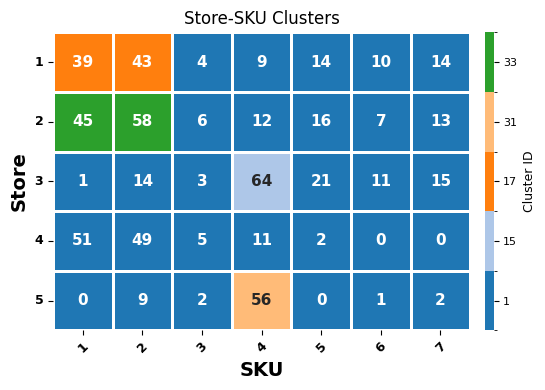

In [43]:
#row_order, col_order = est.get_row_col_orders(assign, df)
#row_order, col_order = est.get_row_col_orders(assign, norm_data2)
df2 = get_normalized_assignments(assign, df)  # contains unique per-cell block_id
#row_order, col_order = get_row_col_orders_smart(df2)
row_order = sorted(df2["store"].unique())
col_order = sorted(df2["item"].unique())

fn = Path("../output/figures/store_item_toy_data_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-SKU Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    x_label="SKU",
    y_label="Store",
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=None,
    xtick_rotation=45,
)

In [48]:
# Freeze your defaults once, then sweep:
make_btf = BinaryTriFactorizationEstimator.factory(
    k_row=None, 
    k_col=None, 
    loss="gaussian", 
    alpha=1e-2, 
    beta=0.6,
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
)
    
# Define your grid
R_list = range(1, 10)
C_list = range(1, 10)

# Run the sweep
grid_df = sweep_btf_grid(
    make_btf,
    X,
    R_list,
    C_list,
    restarts=3,
    seeds=range(123, 999),     # optional
    min_keep=6,
    fit_kwargs={"max_iter": 200, "tol": 1e-4},  # pass your estimator kwargs here
)

# Rank and pick the best (edit ranking logic inside pick_best_btf_setting if desired)
ranked_df, best = pick_best_btf_setting(grid_df)


2025-09-08 08:35:13,126 - INFO - Fitting BTF with R=1, C=1
2025-09-08 08:35:13,140 - INFO - Computing cell mask for R=1, C=1
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,145 - INFO - Fitting BTF with R=1, C=2
2025-09-08 08:35:13,165 - INFO - Computing cell mask for R=1, C=2
/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/BTNMF_util.py:792: RuntimeWarning: Mean of empty slice
  float(np.nanmean(wcvdf["silhouette_like"]))
2025-09-08 08:35:13,170 - INFO - Fitting BTF with R=1, C=3
2025-09-08 08:35:13,192 - INFO - Computing cell mask for R=1, C=3
2025-09-08 08:35:13,196 - INFO - Fitting BTF with R=1, C=4
2025-09-08 08:35:13,227 - INFO - Computing cell mask for R=1, C=4
2025-09-08 08:35:13,231 - INFO - Fitting BTF with R=1, C=5
2025-09-08 08:35:13,252 - INFO - Computing cell mask for R=1, C=5
2025-

In [49]:
best

n_row                                9.000000
n_col                                4.000000
Mask_Nobs                           11.000000
Mask_Coverage                        0.314286
seed                               123.000000
Loss                               193.697610
Percent_Loss                         0.825334
RMSE                                 2.352492
Percent_RMSE                         9.084789
PVE                                  0.977560
Mean Silhouette                      0.588852
BlockContribution_Total          18626.202594
BlockContribution_PerCell         1693.291145
BlockContribution_RelBaseline        5.808148
BlockContribution_FracWeak20         0.000000
BlockContribution_Gini               0.869474
B_Sparsity                           0.642857
Coverage                             1.000000
AIC                                215.928380
BIC                                230.252610
Name: 0, dtype: float64

In [44]:
est.compute_tss_rss_pve(X=X, baseline="grand_mean")

{'tss': 12941.885714285712,
 'rss': 599.2054650132817,
 'pve': 95.37002969859441,
 'baseline': 'grand_mean'}

In [17]:
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral.parquet")
df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq = "W",
    model_name="SpectralBiclustering", # SpectralCoclustering, SpectralBicclustering,
    row_range = range(2, 5),
    col_range = range(2, 5),
    only_best_model = True,
    only_top_n_clusters = 2,
    min_cluster_size = 2,
    skip_invalid = True,
)

2025-08-22 10:04:27,901 - INFO - Number of items: 20
2025-08-22 10:04:27,902 - INFO - Number of stores: 12
2025-08-22 10:04:27,903 - INFO - Building model SpectralBiclustering with n_row=2, n_col=2


2025-08-22 10:04:28,139 - ERROR - [FAIL] n_row=2, n_col=2 → 
2025-08-22 10:04:28,141 - INFO - Building model SpectralBiclustering with n_row=2, n_col=3
2025-08-22 10:04:28,251 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:04:28,251 - INFO -   - Cluster 0: 7 members
2025-08-22 10:04:28,252 - INFO -   - Cluster 1: 5 members
2025-08-22 10:04:28,253 - INFO - [col clusters] expected=3; present=3
2025-08-22 10:04:28,254 - INFO -   - Cluster 0: 16 members
2025-08-22 10:04:28,254 - INFO -   - Cluster 1: 3 members
2025-08-22 10:04:28,255 - INFO -   - Cluster 2: 1 members
2025-08-22 10:04:28,255 - WARNING - [skip] n_row=2, n_col=3: rows<2=[] cols<2=[2]
2025-08-22 10:04:28,256 - INFO - Building model SpectralBiclustering with n_row=2, n_col=4
2025-08-22 10:04:28,385 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:04:28,385 - INFO -   - Cluster 0: 7 members
2025-08-22 10:04:28,386 - INFO -   - Cluster 1: 5 members
2025-08-22 10:04:28,387 - INFO - [col clusters] expected=4

In [16]:
# Example with custom GDKM parameters
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm.parquet")
model_kwargs={
        'max_iter': 200,
        'tol': 1e-5,
        'random_state': 123,
        'norm': 'mav_ratio'  # Try L1 norm instead of L2
    }
 
df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq="W", 
    min_cluster_size = 2,
    skip_invalid = True,
    model_name="GeneralizedDoubleKMeans",
    row_range=range(2, 4),  # Try 2-3 row clusters
    col_range=range(2, 4),  # Try 2-3 column clusters  
    model_kwargs=model_kwargs,
)

2025-08-22 10:03:59,239 - INFO - Number of items: 20
2025-08-22 10:03:59,240 - INFO - Number of stores: 12
2025-08-22 10:03:59,241 - INFO - Building model GeneralizedDoubleKMeans with n_row=2, n_col=2
2025-08-22 10:03:59,242 - INFO - Initialized with norm=mav_ratio, stats=mean
2025-08-22 10:03:59,246 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:03:59,246 - INFO -   - Cluster 0: 1 members


2025-08-22 10:03:59,247 - INFO -   - Cluster 1: 11 members
2025-08-22 10:03:59,247 - INFO - [col clusters] expected=2; present=2
2025-08-22 10:03:59,248 - INFO -   - Cluster 0: 16 members
2025-08-22 10:03:59,249 - INFO -   - Cluster 1: 4 members
2025-08-22 10:03:59,249 - WARNING - [skip] n_row=2, n_col=2: rows<2=[0] cols<2=[]
2025-08-22 10:03:59,250 - INFO - Building model GeneralizedDoubleKMeans with n_row=2, n_col=3
2025-08-22 10:03:59,251 - INFO - Initialized with norm=mav_ratio, stats=mean
2025-08-22 10:03:59,346 - INFO - No column clustering detected.
2025-08-22 10:03:59,347 - INFO - TSS:97.0188764796087,RSS:42.17348368760749, PVE%:56.530641027912274
2025-08-22 10:03:59,347 - INFO - Biclustering with column detected.
2025-08-22 10:03:59,348 - INFO - TSS:97.0188764796087,RSS:72.77858219132492, PVE%:24.98513193293739
2025-08-22 10:03:59,349 - INFO - PVE row-only: 56.53%  |  PVE block: 24.99%
2025-08-22 10:03:59,356 - INFO - Model: GeneralizedDoubleKMeans(n_row_clusters=2, n_col_clus

In [9]:
df2.head()

,date,store_item,store,item,weight,onpromotion,unit_sales,store_cluster,item_cluster,cluster
0,2014-01-01,1_1047679,1,1047679,1,False,0.0,2,1,2_1
1,2014-01-01,1_1168718,1,1168718,1,False,0.0,2,0,2_0
2,2014-01-01,1_1463591,1,1463591,1,False,0.0,2,0,2_0
3,2014-01-01,1_1463992,1,1463992,1,False,0.0,2,2,2_2
4,2014-01-01,1_1464092,1,1464092,1,False,0.0,2,0,2_0


In [15]:

model_kwargs={
    'huber_delta': 1.0,
    'alpha_empty': 200.0,
    'alpha_var': 10,
    'solver': 'batch',
    'tie_breaker': "balance",
    'track_objective': 'l1',
    'use_trace': False,
    'row_batch': 256,
    'col_batch': 256,
    'online_steps': 200,
    'max_iter': 200,
    'tol': 1e-5,
    'random_state': 123,
    'norm': 'l1',  # Try L1 norm instead of L2
}
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm.parquet")

df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq="W", 
    min_cluster_size = 2,
    skip_invalid = True,
    model_name="TiedGDKM",
    row_range=range(2, 4),  # Try 2-3 row clusters
    col_range=range(2, 4),  # Try 2-3 column clusters  
    model_kwargs=model_kwargs,
)


2025-08-22 10:01:04,589 - INFO - Number of items: 20
2025-08-22 10:01:04,590 - INFO - Number of stores: 12
2025-08-22 10:01:04,591 - INFO - Building model TiedGDKM with n_row=2, n_col=2
2025-08-22 10:01:04,596 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:01:04,597 - INFO -   - Cluster 0: 1 members
2025-08-22 10:01:04,597 - INFO -   - Cluster 1: 11 members
2025-08-22 10:01:04,598 - INFO - [col clusters] expected=2; present=2
2025-08-22 10:01:04,599 - INFO -   - Cluster 0: 16 members
2025-08-22 10:01:04,600 - INFO -   - Cluster 1: 4 members
2025-08-22 10:01:04,600 - WARNING - [skip] n_row=2, n_col=2: rows<2=[0] cols<2=[]
2025-08-22 10:01:04,601 - INFO - Building model TiedGDKM with n_row=2, n_col=3
2025-08-22 10:01:04,739 - INFO - No column clustering detected.
2025-08-22 10:01:04,740 - INFO - TSS:97.0188764796087,RSS:42.17348368760749, PVE%:56.530641027912274
2025-08-22 10:01:04,741 - INFO - Biclustering with column detected.
2025-08-22 10:01:04,741 - INFO - TSS:97.018876

In [23]:
df2["store_cluster"].nunique()

3

In [24]:
df2["item_cluster"].nunique()

3

In [25]:
df2.head()

,date,store_item,store,item,weight,onpromotion,unit_sales,store_cluster,item_cluster,cluster
0,2014-01-01,1_1047679,1,1047679,1,False,0.0,2,1,2_1
1,2014-01-01,1_1168718,1,1168718,1,False,0.0,2,0,2_0
2,2014-01-01,1_1463591,1,1463591,1,False,0.0,2,0,2_0
3,2014-01-01,1_1463992,1,1463992,1,False,0.0,2,2,2_2
4,2014-01-01,1_1464092,1,1464092,1,False,0.0,2,0,2_0


In [13]:

def top_n_by_m(df, n_col="unit_sales", group_column="store_nbr", top_n=10):
    """
    Returns the top N stores by total unit sales.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        n_col (str): Column representing sales values.
        group_column (str): Column to group by (e.g., store number).
        top_n (int): Number of top results to return.

    Returns:
        pd.DataFrame: DataFrame of top N stores by total sales.
    """
    return (
        df.groupby(group_column)
        .agg({n_col: "sum"})
        .sort_values(n_col, ascending=False)
        .head(top_n)
    )


In [9]:
# Select top-M items globally
df_top_items = top_n_by_m(
    df, n_col="unit_sales", group_column="item", top_n=9000
)
valid_items = df_top_items.reset_index()["item"].tolist()
print(len(valid_items))
# Select top-N stores globally
df_top_stores = top_n_by_m(
    df, n_col="unit_sales", group_column="store", top_n=51
)
valid_stores = df_top_stores.reset_index()["store"].tolist()
print(len(valid_stores))
unique_dates = df["date"].dropna().unique()
grid = pd.MultiIndex.from_product(
    [valid_stores, valid_items, sorted(unique_dates)],
    names=["store", "item", "date"],
    ).to_frame(index=False)

4036
51


In [4]:
df.to_csv("../data/20250707_train.csv", index=False)

In [4]:
train_df["onpromotion"].unique()

array([nan, False, True], dtype=object)

In [5]:
def top_n_by_m(df, n_col="unit_sales", group_column="store_nbr", top_n=10):
    """
    Returns the top N stores by total unit sales.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        n_col (str): Column representing sales values.
        group_column (str): Column to group by (e.g., store number).
        top_n (int): Number of top results to return.

    Returns:
        pd.DataFrame: DataFrame of top N stores by total sales.
    """
    return df.groupby(group_column).agg({n_col: "sum"}).sort_values(n_col, ascending=False).head(top_n)

def top_values_with_percentage(df, group_column, value_column, n=5):
    """
    Returns the top N values with percentages for each group in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_column (str): The column to group by.
        value_column (str): The column to calculate percentages from.
        n (int): The number of top values to return.

    Returns:
        pd.DataFrame: A DataFrame containing the top N values and their percentages for each group.
    """
    grouped = df.groupby(group_column)[value_column].value_counts(normalize=True) * 100
    grouped = grouped.rename('percentage').reset_index()
    top_n = grouped.groupby(group_column).apply(lambda x: x.nlargest(n, 'percentage')).reset_index(drop=True)
    return top_n


def value_counts_with_percentage(df, column_name, top_n = 10):
    """
    Computes value counts and percentage distribution of a column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        column_name (str): Name of the column to analyze.

    Returns:
        pd.DataFrame: DataFrame with counts and percentages.
    """
    counts = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize=True) * 100
    df = pd.DataFrame({column_name + '_count': counts, column_name + '_percentage': percentages})
    return df.sort_values(column_name, ascending=False).head(top_n)

In [6]:
df = top_n_by_m(train_df, n_col="unit_sales", group_column="store_nbr", top_n=100)

In [7]:
df

,unit_sales
store_nbr,
44,62087544.00
45,54498012.00
47,50948308.00
3,50481900.00
49,43420088.00
46,41896052.00
48,35933132.00
51,32911484.00
8,30491336.00


In [8]:
# df.reset_index().to_excel(
#     "../output/data/20250627_top_100_store_sale.xlsx",
#     index=False
# )


In [9]:
# assuming df.reset_index()["store_nbr"] gives you the list of valid stores:
valid_stores = df.reset_index()["store_nbr"].tolist()

# Filter train_df to only rows whose store_nbr is in that list:
train_df_filtered = train_df[ train_df["store_nbr"].isin(valid_stores) ]


In [10]:
train_df_filtered = train_df_filtered.reset_index()
train_df_filtered.drop(["index"], axis=1, inplace=True)

In [11]:
train_df_filtered.head(4)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN


In [19]:
train_df_filtered["store_nbr"].nunique()

54

In [20]:
#top_values_with_percentage(train_df_filtered, "store_nbr", "unit_sales")

In [14]:
def count_percent(series, n=3):
    counts = series.value_counts().head(n)
    percentages = counts / series.count() * 100
    result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    return result

In [15]:
count_percent(train_df["item_nbr"], n=10)

,Count,Percentage
item_nbr,,
502331,83475,0.066516
314384,83450,0.066496
364606,83308,0.066382
265559,83047,0.066174
559870,82513,0.065749
1036689,82134,0.065447
273528,82108,0.065426
564533,82086,0.065409
261052,81774,0.065160


In [16]:
len(train_df_filtered)

125497040

In [17]:
# assuming df.reset_index()["store_nbr"] gives you the list of valid stores:
valid_item = count_percent(train_df_filtered["item_nbr"], n=500).reset_index()["item_nbr"].tolist()

# Filter train_df to only rows whose store_nbr is in that list:
train_df_filtered = train_df_filtered[ train_df_filtered["item_nbr"].isin(valid_item) ]
train_df_filtered.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


In [29]:
len(train_df_filtered)

34824868

In [19]:
print(train_df_filtered["store_nbr"].nunique())
print(train_df_filtered["item_nbr"].nunique())

54
500


In [20]:
 # Save to a new CSV
 
train_df_filtered.to_csv(
    "../output/data/20250630_train_top_store_500_item.csv",
    index=False
)

In [7]:
train_df["date"] = pd.to_datetime(train_df["date"])
min_date = train_df['date'].min()
cutoff_date = min_date + pd.Timedelta(days=90)

# 3. Filter to the first 30 days
first_n_days = train_df[
    (train_df['date'] >= min_date) &
    (train_df['date'] <= cutoff_date)
].copy()

# 4. (Optional) Sort if you want chronological order
first_n_days.sort_values(['date', 'store_nbr', 'item_nbr'], inplace=True)

In [8]:
first_n_days.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [9]:
first_n_days.reset_index(drop=True, inplace=True)

In [10]:
first_n_days["date"].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00', '2013-01-11 00:00:00', '2013-01-12 00:00:00',
 '2013-01-13 00:00:00', '2013-01-14 00:00:00', '2013-01-15 00:00:00',
 '2013-01-16 00:00:00', '2013-01-17 00:00:00', '2013-01-18 00:00:00',
 '2013-01-19 00:00:00', '2013-01-20 00:00:00', '2013-01-21 00:00:00',
 '2013-01-22 00:00:00', '2013-01-23 00:00:00', '2013-01-24 00:00:00',
 '2013-01-25 00:00:00', '2013-01-26 00:00:00', '2013-01-27 00:00:00',
 '2013-01-28 00:00:00', '2013-01-29 00:00:00', '2013-01-30 00:00:00',
 '2013-01-31 00:00:00', '2013-02-01 00:00:00', '2013-02-02 00:00:00',
 '2013-02-03 00:00:00', '2013-02-04 00:00:00', '2013-02-05 00:00:00',
 '2013-02-06 00:00:00', '2013-02-07 00:00:00', '2013-02-08 00:00:00',
 '2013-02-09 00:00:00', '2013-02-10 00:00:00', '2013-02-11 00:00:00',
 '20

In [11]:
 # Save to a new CSV
first_n_days.to_csv(
    "./data/train_first_90_days.csv",
    index=False
)

print(f"Kept records from {min_date.date()} to {cutoff_date.date()} – {len(first_n_days)} rows saved.")


Kept records from 2013-01-01 to 2013-04-01 – 3738322 rows saved.


In [12]:
train_df.groupby(["store_nbr","item_nbr"]).agg({"id":"count"})

id
store_nbr item_nbr      
1         96995      187
          99197      185
          103520    1119
          103665    1358
          105574    1546
...                  ...
54        2110456     47
          2113343      8
          2113914     36
          2116416     11
          2124052      1

[174685 rows x 1 columns]

In [13]:
train_df["item_nbr"].nunique()

4036

In [14]:
train_df["store_nbr"].nunique()

54

In [15]:
train_df.shape

(125497040, 6)

In [16]:
train_df.groupby("store_nbr").agg({"unit_sales":"sum"}).sort_values("unit_sales",ascending=False).head(10)

,unit_sales
store_nbr,
44,62087544.0
45,54498012.0
47,50948308.0
3,50481900.0
49,43420088.0
46,41896052.0
48,35933132.0
51,32911484.0
8,30491336.0


In [9]:
top_n_by_m(train_df)

,unit_sales
store_nbr,
3,24060.347656
8,14659.328125
6,13520.485352
7,11997.501953
5,10598.619141
2,10266.718750
4,10200.083984
9,9757.633789
1,7417.147949


In [11]:
value_counts_with_percentage(train_df, "item_nbr")

,item_nbr_count,item_nbr_percentage
item_nbr,,
165718,10,0.10
103665,10,0.10
165705,10,0.10
165704,10,0.10
115267,10,0.10
...,...,...
268446,1,0.01
279125,1,0.01
302824,1,0.01


In [13]:
df = train_df.groupby("date")["unit_sales"].sum().reset_index()  # Aggregate daily sales

In [14]:
df.shift(5)

,date,unit_sales
0,None,NaN
1,None,NaN
